# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## April 02, 2020

## Overview

This notebook contains the TensorFlow model training and prediction used to segment trees for [Restoration Mapper](https://restorationmapper.org). The notebook uses tensorflow 1.13.1 and additionally relies on Keras and tflearn. 

## Table of Contents

- Package loading
- Utility scripts
- Hyperparameter definitions
- Custom tensorflow layer functions
- Tensorflow graph creation
- Data loading
- Data preprocessing
- Equibatch creation
- Loss definition
- Tensorflow graph initialization
- Training
- Model validation
- Sanity Checks

## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf
#import tensorflow_probability as tfp


sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Utility scripts

In [4]:
%run ../src/layers/zoneout.py
%run ../src/layers/adabound.py
%run ../src/layers/convgru.py
%run ../src/layers/dropblock.py
%run ../src/layers/extra_layers.py
%run ../src/preprocessing/indices.py
%run ../src/preprocessing/slope.py
%run ../src/utils/metrics.py
%run ../src/utils/lovasz.py

E0114 12:22:19.910055 4683158976 execution.py:709] File `'../src/utils/lovasz.py'` not found.


# Hyperparameter definitions

In [5]:
ZONE_OUT_PROB = 0.20

ACTIVATION_FUNCTION = 'swish'

INITIAL_LR = 5e-5
DROPBLOCK_MAXSIZE = 4
DECONV = 'upconv'
N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.33
LABEL_SMOOTHING = 0.03
BATCH_RENORM = 'renorm'

L2_REG = 5e-4
BN_MOMENTUM = 0.90
BATCH_SIZE = 20
MAX_DROPBLOCK = 0.95

GRU_FLT = 24
OUT_FLT = 48

IMAGE_SIZE = 24
LABEL_SIZE = 14

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [6]:
def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv GRU Block

In [7]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {0.1}")
        """
        cell_fw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        cell_bw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        """
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = 0.2, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = 0.2, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"Down block output shape {gru.shape}")
    return gru, steps

### Conv blocks

In [8]:
def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 clipping_params,
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    bn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    csse_flag = "CSSE" if csse else "No CSSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    
    print("{} {} Conv 2D {} {} {} {} {}".format(scope, kernel_size,
                                                   bn_flag, activation_flag,
                                                   csse_flag, bias_flag, drop_flag))
    
    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      kernel_regularizer = weight_decay,
                      kernel_initializer = tf.keras.initializers.he_normal())(inp)
    if activation:
        conv = tf.nn.swish(conv)
    #
    if norm:
        conv = group_norm(x = conv, scope = scope, G = 8)
    if csse:
        #with tf.variable_scope(scope + "_csse"):
            #conv = csse_block(conv, scope + "_csse")
        conv = csse_block(conv, "csse_" + scope)
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
            conv = drop_block(conv, is_training)
    return conv

# Model definition

## Placeholders

In [9]:
n_bands = 15 # 16 for master model
reg = tf.contrib.layers.l2_regularizer(L2_REG)
inp = tf.placeholder(tf.float32, shape=(None, 13, 24, 24, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ())


#inp_median = tf.placeholder(tf.float32, shape = (None, 24, 24, n_bands))

In [10]:
rmax = tf.placeholder(tf.float32, shape = ())
rmin = tf.placeholder(tf.float32, shape = ())
dmax = tf.placeholder(tf.float32, shape = ())

clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}

## Layers

In [11]:
def create_deconv_init(filter_size, num_channels):
    '''Initializes a kernel weight matrix with a bilinear deconvolution
    
         Parameters:
          filter_size (int): kernel size of convolution
          num_channels (int): number of filters for convolution

         Returns:
          bilinear_init (tf.Variable): [filter_size, filter_size, num_channels] kernel
    '''
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init

def get_deconv2d(inp, filter_count, num_channels, scope, is_training, clipping_params, keep_rate):
    '''Creates a deconvolution layer with Conv2DTranspose. Following recent
       recommendations to use 4 kernel, 2 stride to avoid artifacts. 
       Initialize kernel with bilinear upsampling.

         Parameters:
          inp (tf.Variable): input tensorflow layer (B, X, Y, C) shape
          filter_count (int): number of filters for convolution
          num_channels (int): number of output channels
          scope (str): tensorflow variable scope
          is_training (str): flag to differentiate between train/test ops
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): layer with (B, x * 2, y * 2, C) shape
          
         References:
          https://distill.pub/2016/deconv-checkerboard/
    '''
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='valid', 
                                        use_bias = False,
                                        kernel_initializer = bilinear_init)(inp)
    x = Cropping2D(1)(x)
    x = tf.nn.relu(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn", clipping_params = clipping_params)
    
    x = csse_block(x, 'csse_' + scope)
    with tf.variable_scope(scope + "_drop"):
        drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
        x = drop_block(x, is_training)
    return x

## Model

The model uses a UNet architecture where the encoder extracts increasingly abstract features and the decoder upsamples the features to the target resolution.

The encoder consists of three blocks:

- GRU: A bidirectional convolutional GRU with channel squeeze and spatial excitation, and group normalization, extracts 3x3 features from the multitemporal imagery
- Conv1: A MaxPool-conv-swish-groupNorm-csse layer takes the output of the GRU (size 24) and reduces to size 12
- Conv2: The output of the MaxPool-conv-swish-csse-DropBlock is a 4x4x80 encoded feature map

Some notes on the encoder: 

- Conv2 does not have a groupNorm layer because its small size (4x4) would make the means and standard deviations highly variable over such small inputs
- Conv1 has a groupNorm layer so that the concatenations in the decoder are consistent (1/2 no GN, 1/2 GN)
- Conv1 does not have a dropblock because it empirically performs better

The decoder consists of two blocks:

- Upconv1: upsample-conv-swish-csse-concat-conv-swish
- Upconv2: upsample-conv-swish-csse-concat-conv-swish
- Output sigmoid


In [12]:
# Master model is 48 -> 64 -> 80 -> 64 -> 48
# Teset with 48 -> 72 -> 96
# Test with 48 -> 80 -> 112

# The GRU uses group normalization with G = 6

gru_input = inp[:, :12, ...]
gru, steps = gru_block(inp = gru_input, length = length2,
                            size = [24, 24],
                            flt = 24,
                            scope = 'down_16',
                            train = is_training)
with tf.variable_scope("gru_drop"):
    drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
    gru = drop_block(gru, is_training)
    
# Median conv
median_input = inp[:, -1, ...]
median_pad = ReflectionPadding2D((1, 1,))(median_input)
median_conv = conv_swish_gn(inp = median_pad, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = 48, clipping_params = clipping_params,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None)

concat = tf.concat([gru, median_conv], axis = -1)
concat = conv_swish_gn(inp = concat, is_training = is_training, stride = (1, 1),
            kernel_size = 1, scope = 'conv_concat', filters = 48, clipping_params = clipping_params,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = False, dropblock = False, weight_decay = None)

    
# MaxPool-conv-swish-GroupNorm-csse
# This block does use GN so that skip connections in decoder block have
# one-half GN normalized activations
pool1 = MaxPool2D()(concat)
pool1 = ReflectionPadding2D((1, 1,))(pool1)
conv1 = conv_swish_gn(inp = pool1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = 64, clipping_params = clipping_params,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = False, weight_decay = None)
print(conv1.shape)

# MaxPool-conv-swish-csse-DropBlock
# This block doesn't use GN because with only a size of 4x4 the mean and stdev are very variable
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = 80, clipping_params = clipping_params,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None)
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
# The decoder doesn't use any GN because empirically this performs better
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = 64, clipping_params = clipping_params,
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None)
conv1_crop = Cropping2D(2)(conv1)
up2 = tf.concat([up2, conv1_crop], -1)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 1, scope = 'up2_out', filters = 64, clipping_params = clipping_params,
                    keep_rate =  keep_rate, activation = True, use_bias = False, norm = True,
                    csse = False, dropblock = False, weight_decay = None)

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = 48, clipping_params = clipping_params,
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None)
# CHECK THIS
gru_crop = Cropping2D(4)(concat)
up3 = tf.concat([up3, gru_crop], -1)

up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = 48, clipping_params = clipping_params,
                    keep_rate  = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = False, dropblock = False, weight_decay = None)


print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(up3) # For focal loss

print(f"The output, sigmoid is {fm.shape}, with a receptive field of {1}")

GRU input shape (?, 12, 24, 24, 15), zoneout: 0.1


W0114 12:22:29.030117 4683158976 module_wrapper.py:139] From /Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



(3, 3, 39, 48)
(3, 3, 39, 48)
Down block output shape (?, 24, 24, 48)


W0114 12:22:30.386059 4683158976 module_wrapper.py:139] From /Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0114 12:22:30.503447 4683158976 module_wrapper.py:139] From /Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



conv_median 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
conv_concat 1 Conv 2D Group Norm RELU No CSSE NoBias NoDrop
conv1 3 Conv 2D Group Norm RELU CSSE NoBias NoDrop
(?, 12, 12, 64)
conv2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Encoded (?, 4, 4, 80)
up2 3 Conv 2D Group Norm RELU CSSE NoBias NoDrop
up2_out 1 Conv 2D Group Norm RELU No CSSE NoBias NoDrop
up3 3 Conv 2D Group Norm RELU CSSE NoBias NoDrop
out 3 Conv 2D Group Norm RELU No CSSE NoBias NoDrop
Initializing last sigmoid bias with -2.94 constant
The output is (?, 8, 8, 64), with a receptive field of 1
The output, sigmoid is (?, 14, 14, 1), with a receptive field of 1


In [13]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print(f"This model has {total_parameters} parameters")

This model has 280030 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [15]:
import hickle as hkl
normalize = False
train_x = hkl.load("../tile_data/processed/train_x.hkl")
train_y = hkl.load("../tile_data/processed/train_y.hkl")
train_l = hkl.load("../tile_data/processed/train_l.hkl")
print(train_x.shape)

data = pd.read_csv("../tile_data/processed/train_plot_ids.csv")
print(len(train_x))

(627, 13, 24, 24, 15)
627



# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [60]:
below_1 = [i for i, val in enumerate(train_x[..., :10]) if np.min(val) < -2]
above_1 = [i for i, val in enumerate(train_x[..., :10]) if np.max(val) > 2]
min_vals = [np.min(val) for i, val in enumerate(train_x[..., :10]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(train_x[..., :10]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(train_x) if np.sum(np.isnan(val)) > 100]
oob_vals = [i for i, val in enumerate(train_x) if np.max(val[..., 0]) > 0.7]

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print("Removing {} outlying training data points".format(len(outliers)))
print(sorted(outliers))
train_x = np.delete(train_x, outliers, 0)
train_y = np.delete(train_y, outliers, 0)
train_l = np.delete(train_l, outliers)
data = data.drop(outliers, 0)
data.reset_index(inplace = True, drop = True)

print(train_x.shape)

Removing 35 outlying training data points
[241, 1805, 3188, 3552, 3558, 3561, 3579, 3580, 3588, 3603, 3614, 3642, 3644, 3675, 3690, 3699, 3706, 3710, 3717, 3722, 3734, 3741, 3769, 3778, 3788, 3886, 3890, 3902, 3907, 3911, 3924, 3927, 3932, 3935, 3938]
279     135224891
707     135546356
1021    135680269
1113    135680839
1772    135703889
2477    135787648
Name: plot_id, dtype: int64
(4726, 13, 24, 24, 15)


## Normalization

In [16]:
if normalize:
    means = []
    stds = []
    for band in tnrange(0, train_x.shape[-1]):
        mn = np.mean(train_x[..., band])
        std = np.std(train_x[..., band])
        normed = (train_x[..., band] - mn) / std
        normed[np.where(normed > 3)] = 3.
        normed[np.where(normed < -3)] = -3.
        train_x[..., band] = normed
        print(np.mean(train_x[..., band]))
        print(np.std(train_x[..., band]))
        means.append(mn)
        stds.append(std)

## Standardization

In [19]:
min_all = [0.015521813509985806,
 0.02992593664675951,
 0.017449956107884645,
 0.07766134440898895,
 0.048788430541753774,
 0.07196633368730546,
 0.07878162041306495,
 0.08162999972701074,
 0.05668189264833927,
 0.03447630386799574,
 0.0,
 0.0001680145083810212,
 -0.37605413943529126,
 0.0007385778590105491,
 -0.0016330641694366804]
           
max_all = [0.19387827888131137,
 0.2909853518009182,
 0.42694036215543685,
 0.5081990957260132,
 0.4705589339137064,
 0.4819881334900855,
 0.5039300978183743,
 0.5146166324615464,
 0.6550798445940016,
 0.5976870089769362,
 0.36693188548088074,
 0.7027038395404812,
 0.29841530919074977,
 0.6481115818023682,
 0.8881663084030151]

In [20]:
if not normalize:
    #
    #min_all = []
    #max_all = []
    #
    for band in tnrange(0, train_x.shape[-1]):
        #mins = np.percentile(train_x[:, ..., band], 1)
        #maxs = np.percentile(train_x[:, ..., band], 99)
        mins = min_all[band]
        maxs = max_all[band]
        #print(mins1 - mins, maxs1 - maxs)
        train_x[..., band] = np.clip(train_x[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (train_x[..., band] - midrange) / (rng / 2)
        train_x[..., band] = standardized

        min_all.append(mins)
        max_all.append(maxs)

    print("The data has been scaled to [{}, {}]".format(np.min(train_x), np.max(train_x)))
    print(min_all, max_all)
    #np.save("min_all.npy", min_all)
    #np.save("max_all.npy", max_all)



The data has been scaled to [-1.0000001192092896, 1.0]
[0.015521813509985806, 0.02992593664675951, 0.017449956107884645, 0.07766134440898895, 0.048788430541753774, 0.07196633368730546, 0.07878162041306495, 0.08162999972701074, 0.05668189264833927, 0.03447630386799574, 0.0, 0.0001680145083810212, -0.37605413943529126, 0.0007385778590105491, -0.0016330641694366804, 0.015521813509985806, 0.02992593664675951, 0.017449956107884645, 0.07766134440898895, 0.048788430541753774, 0.07196633368730546, 0.07878162041306495, 0.08162999972701074, 0.05668189264833927, 0.03447630386799574, 0.0, 0.0001680145083810212, -0.37605413943529126, 0.0007385778590105491, -0.0016330641694366804] [0.19387827888131137, 0.2909853518009182, 0.42694036215543685, 0.5081990957260132, 0.4705589339137064, 0.4819881334900855, 0.5039300978183743, 0.5146166324615464, 0.6550798445940016, 0.5976870089769362, 0.36693188548088074, 0.7027038395404812, 0.29841530919074977, 0.6481115818023682, 0.8881663084030151, 0.1938782788813113

# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

## Load and process test data

In [18]:
test_x = hkl.load("data/test/test_x.hkl")
#test_x = test_x[:, :, 3:-3, 3:-3, :]
test_y = hkl.load("data/test/test_y.hkl")
test_lengths = hkl.load("data/test/test_lengths.hkl")
test_data = pd.read_csv("data/test/test_plot_ids.csv")
print(test_x.shape)
print(test_x.shape)

outliers = [184, 534, 679]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_lengths = np.delete(test_lengths, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

below_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.min(val) < -1.66]
above_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.max(val) > 1.66]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("There are {} outliers: {}".format(len(outliers), outliers))
outliers = [571, 958]
print("There are {} outliers: {}".format(len(outliers), outliers))

test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_lengths = np.delete(test_lengths, outliers, 0)
#print([x for x in test_data['plot_id'].iloc[outliers]])
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

outliers = [206, 212, 498, 551, 573, 673, 710, 894, ]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_lengths = np.delete(test_lengths, outliers, 0)
#print([x for x in test_data['plot_id'].iloc[outliers]])
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

outliers = [528, 652, 878, 888, 912, ]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_lengths = np.delete(test_lengths, outliers, 0)
#print([x for x in test_data['plot_id'].iloc[outliers]])
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

outliers = [124, 180]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_lengths = np.delete(test_lengths, outliers, 0)
#print([x for x in test_data['plot_id'].iloc[outliers]])
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

outliers = [555, 559, 563, 602, 747, 912, 918, ]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_lengths = np.delete(test_lengths, outliers, 0)
#print([x for x in test_data['plot_id'].iloc[outliers]])
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

outliers = [751, 924, 896]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_lengths = np.delete(test_lengths, outliers, 0)
#print([x for x in test_data['plot_id'].iloc[outliers]])
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

print(test_x.shape)
#print(test_data.shape)

(1020, 13, 24, 24, 15)
(1020, 13, 24, 24, 15)
There are 0 outliers: []
There are 2 outliers: [571, 958]
(990, 13, 24, 24, 15)


In [19]:
# Test normalization
if normalize:
    print("Normalizing data")
    for band in tnrange(0, test_x.shape[-1]):
        print(f"{band}, mean, {abs(np.mean(test_x[..., band]) - means[band])}")
        print(f"{band}, std, {abs(np.std(test_x[..., band]) - stds[band])}")
        normed = (test_x[..., band] - means[band]) / stds[band]
        normed[np.where(normed > 3)] = 3.
        normed[np.where(normed < -3)] = -3.
        test_x[..., band] = normed

        means.append(mn)
        stds.append(std)

In [20]:
if not normalize:
    for band in range(0, train_x.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        test_x[..., band] = np.clip(test_x[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (test_x[..., band] - midrange) / (rng / 2)
        test_x[..., band] = standardized
    
    
    print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))


The data has been scaled to [-1.0000001192092896, 1.0]


In [21]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))

#print(f"There are {len(train_ids)} train and {len(test_ids)} test samples")
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 68.27373737373738
Test STD Y 78.57391050014351


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

In [21]:
sums = np.sum(train_y, axis = (1, 2))
percents = [np.percentile(sums, x) for x in range(30, 100, 9)]
print(percents)
print("There are {} zeros".format(len(np.argwhere(sums == 0))))

[11.799999999999983, 22.140000000000015, 36.0, 50.81999999999999, 71.0, 107.5, 149.0, 179.18000000000006]
There are 110 zeros


In [22]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots
    
         Parameters:
          matrices (list of arrays):

         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])

def equibatch(train_ids, p = percents):
    '''Docstring
    
         Parameters:
          train_ids (list):
          p (list):

         Returns:
          equibatches (list):
    '''
    percents = [9.0, 19.0, 29.0, 40.0, 64.0, 95.0, 145.0] # sept 28
    percents = [9.0, 19.0, 28.0, 40.0, 62.0, 100.0, 155.0] # november
   # percents =  [7.0, 13.0, 21.0, 33.0, 50.0, 80.0, 130.0] # overall
    #percents = [12.0, 24.0, 42.0, 65.0, 90.0, 125., 170.0] # lac
    #percents = [9.0, 19.0, 29.0, 40.0, 55.0, 85.0, 150.0] # east africa
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z <= 2]
    ids30 = [x for x, z in zip(ix, percs) if 2 < z <= percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z <= percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z <= percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z <= percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z <= percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z <= percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z <= percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    
    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    print(sum(maxes))
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes))
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]],
                    ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]], ids60[cur_ids[4]], 
                    ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        
    new_batches = [item for sublist in new_batches for item in sublist]
    return new_batches

batch = equibatch(train_ids)

[128, 50, 51, 40, 55, 67, 67, 85, 84]
627


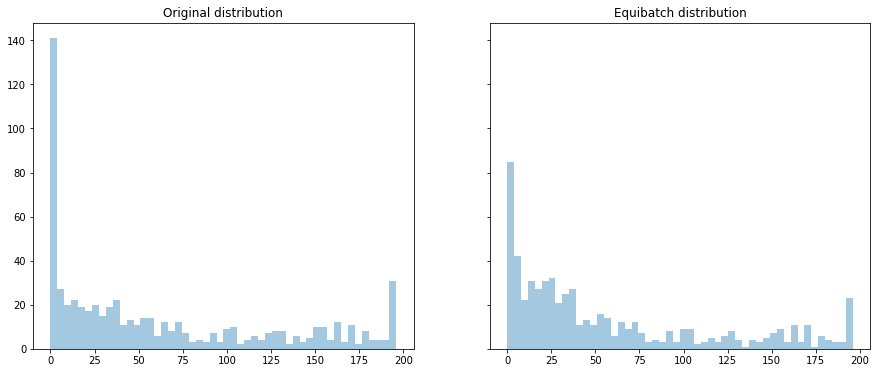

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(15, 6)
sns.distplot(np.sum(train_y, axis = (1, 2)), bins = 50, kde = False, ax = ax1)
ax1.set_title('Original distribution')
ax2.set_title('Equibatch distribution')
sns.distplot(np.sum(train_y[batch], axis = (1, 2)),
             bins = 50, kde = False, ax = ax2)

plt.show()

# Example equibatch

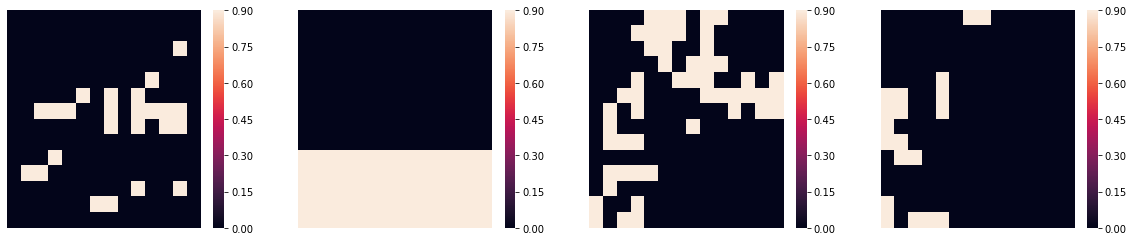

In [24]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

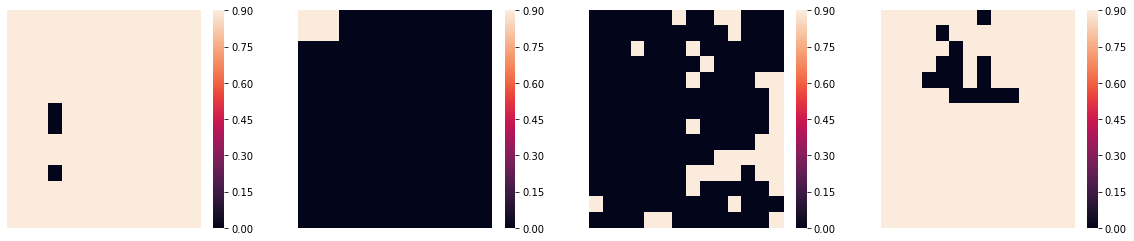

In [25]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

## Weight cross entropy by effective number of samples

In [26]:
sum_pos = np.sum(train_y[batch], axis = (1, 2))
sum_pos = sum_pos[sum_pos != 196]
n_pos = len(train_y) - len(sum_pos)
sum_pos = np.sum(sum_pos)
sum_neg = np.sum(train_y[batch], axis = (1, 2))
sum_neg = sum_neg[sum_neg != 0]
n_neg = len(train_y) - len(sum_neg)
sum_neg = (len(train_y) - (n_neg + n_pos)) * 196
print(sum_pos, sum_neg)
beta = 0.999
print("Beta: {}".format(beta))
samples_per_cls = np.array([sum_neg, sum_pos]) / 196
print(samples_per_cls)
effective_num = 1.0 - np.power(beta, samples_per_cls)
print(effective_num)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights / np.sum(weights)
print("Neg and pos weights: {}".format(weights))
weight = weights[1] / weights[0]
print(weight)
weight = 1.7

31974.0 105644
Beta: 0.999
[539.         163.13265306]
[0.416826   0.15059084]
Neg and pos weights: [0.2653972 0.7346028]
2.767937326416497


In [27]:
print("Baseline: The positive is: {}".format(weights[0]))
print("Baseline: The negative is: {}".format(weights[1]))
print("\n")
print("Balanced: The positive is: {}".format(weight*weights[0]))
print("Balanced: The negative is: {}".format(weights[1]))


Baseline: The positive is: 0.26539719569886044
Baseline: The negative is: 0.7346028043011396


Balanced: The positive is: 0.45117523268806276
Balanced: The negative is: 0.7346028043011396



# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [28]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def calc_mask(seg):

    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        #res[np.where(res == 0)] = -1 * loss_importance[196 - sums]
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    res[np.logical_and(res < 2, res > 0)] = 0.5
    res[np.logical_or(res >= 2, res <= 0)] = 1.
    return res# / max_value

def calc_mask_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    bce_batch = np.array([calc_mask(y)
                     for y in y_true_numpy]).astype(np.float32)
    return bce_batch

def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.03):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )

    return loss

def calc_dist_map(seg):
    #Utility function for calc_dist_map_batch that calculates the loss
    #   importance per pixel based on the surface distance function
    
     #    Parameters:
    #      seg (arr):
     #     
    #     Returns:
    #      res (arr):
    #
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 2
                if sums2 <= 1:
                    ones[x - 1, y] = 0.25
                    ones[x + 1, y] = 0.25
                    ones[x, y + 1] = 0.25
                    ones[x, y - 1] = 0.25
                    ones[x - 1, y + 1] = 0.25
                    ones[x + 1, y + 1] = 0.25
                    ones[x + 1, y - 1] = 0.25
                    ones[x -1, y - 1] = 0.25

    if posmask.any():
        
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        #res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res# / max_value


def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    #loss = K.mean(multipled)
    return loss


def lovasz_surf(y_true, y_pred, alpha, weight, beta):
    
    #lv = lovasz_softmax(probas = y_pred,
    #                    labels = tf.reshape(y_true, (-1, 14, 14)), 
    #                    classes=[1],
    #                    per_image=True) 
    
    bce = weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.03)

    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    surface = surface_loss(y_true, y_pred)

    #bce_mask = tf.math.reduce_sum(y_true, axis = (1, 2, 3))
    #bce_mask = tf.cast(bce_mask, tf.float32)
    #bce_mask_low = tf.math.less(bce_mask, tf.constant([1.]))
    #bce_mask_high = tf.math.greater(bce_mask, tf.constant([195.]))
    
    #bce_mask_low = tf.cast(bce_mask_low, tf.float32)
    #bce_mask_high = tf.cast(bce_mask_high, tf.float32)
    #bce_mask = bce_mask_low + bce_mask_high
    #print("BCE mask", bce_mask.shape)
    #surface = (surface * (1 - bce_mask)) + (bce_mask * bce)
    surface = tf.reduce_mean(surface)
    
    
    #lovasz = (lv * lv_mask) + (bce * bce_mask)
    #lovasz = tf.reduce_mean(lovasz)
    #lovasz_portion = (1 - alpha) * lovasz
    #lovasz_portion = lovasz_portion * beta
    bce = tf.reduce_mean(bce)

    bce = (1 - alpha) * bce
    #bce = bce * (1 - beta)
    surface_portion = alpha * surface
    result = bce + surface_portion
    return result


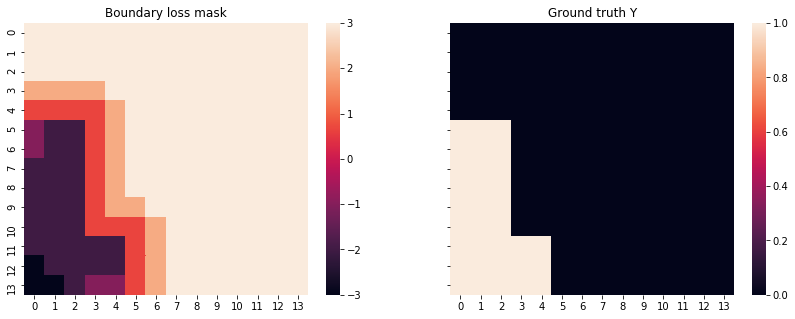

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(14, 5)
sns.heatmap(calc_dist_map(train_y[-13]), ax = ax1)
ax2.set_title('Ground truth Y')
ax1.set_title('Boundary loss mask')
sns.heatmap(train_y[-13], ax = ax2)
plt.show()

# Evaluation metrics

In [30]:
countries = {'all': [0, 1150]}

def dice_loss_tolerance(y_true, y_pred):
    numerator_data = np.zeros_like(y_true)
    for x in range(y_true.shape[0]):
        for y in range(y_true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([y_true.shape[0], y+2])
            max_x = np.min([y_true.shape[0], x+2])
            if y_true[x, y] == 1:
                numerator_data[x, y] = np.max(y_pred[min_x:max_x, min_y:max_y])
                
    numerator = 2 * np.sum(y_true * numerator_data, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)
                    
            
        
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    return np.sum(tp), np.sum(fp), np.sum(fn)

def calculate_metrics(country, al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics for an input country, based on
       indexing of the country dictionary:
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          country (str):
          al (float):
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    print(canopy_thresh)
    start_idx = 0
    stop_idx = len(test_x)
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    hausdorff = 0
    relaxed_f1 = 0
    preds = []
    vls = []
    trues = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197):
            x_input = test_x[test_sample].reshape(1, 13, 24, 24, n_bands)
            x_median_input = calc_median_input(x_input)
            y, vl = sess.run([fm, test_loss], feed_dict={inp: x_input,
                                                          #inp_median: x_median_input,
                                                          length: np.full((1, 1), 12),
                                                          is_training: False,
                                                          clipping_params['rmax']: 5,
                                                          clipping_params['rmin']: 0,
                                                          clipping_params['dmax']: 3,
                                                          labels: test_y[test_sample].reshape(1, 14, 14),
                                                          loss_weight: 1.5,
                                                          alpha: al,
                                                          })
            preds.append(y.reshape((14, 14)))
            vls.append(vl)
            trues.append(test_y[test_sample].reshape((14, 14)))
    dice_losses = []
    for thresh in range(9, 10):
        tps_relaxed = np.empty((len(preds), ))
        fps_relaxed = np.empty((len(preds), ))
        fns_relaxed = np.empty((len(preds), ))
        abs_error = np.empty((len(preds), ))
        
        for sample in range(len(preds)):
            pred = np.copy(preds[sample])
            true = trues[sample]
            if thresh == 8:
                if np.sum(true + pred) > 0:
                    dice_losses.append(0.5)
                   # dice_losses.append(dice_loss_tolerance(np.array(true), np.array(pred)))
                else:
                    dice_losses.append(1.)
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error[sample] = abs(true_s - pred_s)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed[sample] = tp_relaxed
            fps_relaxed[sample] = fp_relaxed
            fns_relaxed[sample] = fn_relaxed                   
            
        oa_error = np.mean(abs_error)
        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        
        if f1_r > best_f1:
            haus = np.zeros((len(preds), ))
            for sample in range(len(preds)):
                pred = np.copy(preds[sample])
                pred[np.where(pred >= thresh*0.05)] = 1
                pred[np.where(pred < thresh*0.05)] = 0
                true = trues[sample]
                #dists = compute_surface_distances(np.array(true).reshape(14, 14, 1).astype(int),
                #                                  np.array(pred).reshape(14, 14, 1).astype(int),
                #                                  [1, 1, 1])
                #if np.sum(true + pred) > 0:
                #    haus_i = compute_robust_hausdorff(dists, 50)
                #    if not np.isinf(haus_i):
                #        haus[sample] = haus_i
                #if np.sum(true + pred) == 0:
                #    haus[sample] = 0.
                    
            dices = np.mean(dice_losses)
            haus = np.mean(haus)
            best_dice = 0.5
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            best_thresh = thresh*0.05
            best_haus = 0.5
    print(f"{country}: Val loss: {np.around(np.mean(vls), 3)}"
          f" Thresh: {np.around(best_thresh, 2)}"
          f" F1: {np.around(best_f1, 3)} R: {np.around(p, 3)} P: {np.around(r, 3)}"
          f" D: {np.around(np.mean(best_dice), 3)} H: {np.around(best_haus, 3)}"
          f" Error: {np.around(error, 3)}")
    return np.mean(vls), best_f1, error, best_haus, np.mean(best_dice)

# Graph set up

In [31]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    x = train_x[batch_ids]
    y = train_y[batch_ids]
    x_batch = np.zeros_like(x)
    y_batch = np.zeros_like(y)
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i] = x[i]
            y_batch[i] = y[i]
        if current_flip == 1:
            x_batch[i] = np.flip(x[i], 1)
            y_batch[i] = np.flip(y[i], 0)
        if current_flip == 2:
            x_batch[i] = np.flip(x[i], [2, 1])
            y_batch[i] = np.flip(y[i], [1, 0])
        if current_flip == 3:
            x_batch[i] = np.flip(x[i], 2)
            y_batch[i] = np.flip(y[i], 1)

    y_batch = y_batch.reshape((batch_size, 14, 14))
    return x_batch, y_batch

x_batch_test, y_batch_test = augment_batch([0, 1, 2], 3)

In [32]:
def calc_median_input(x_batch):
    x_median = np.percentile(x_batch, 25, axis = (1))
    return x_median

x_batch_med = calc_median_input(x_batch_test)

In [35]:
# 266k-master-adabound-5e-4to5e-2 is really 3e-4 to 
FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 100
LEARNING_RATE = 3e-3
#test_ids = [x for x in range(0, len(test_x))]

print(f"Starting model with: \n {ZONE_OUT_PROB} zone out \n {L2_REG} l2 \n"
      f"{INITIAL_LR} initial LR \n {total_parameters} parameters")        
    
if FRESH_START:
    #print(f"Restarting training from scratch on {len(train_ids)} train and {len(test_ids)} test samples")
    optimizer = AdaBoundOptimizer(1e-3, ft_lr)
    train_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)), 
                             fm, weight = loss_weight, 
                             alpha = alpha, beta = beta_)
    l2_loss = tf.losses.get_regularization_loss()
    if len(tf.losses.get_regularization_losses()) > 0:
        print("Adding L2 loss")
        train_loss = train_loss + l2_loss
    ft_optimizer = tf.train.MomentumOptimizer(ft_lr, momentum = 0.8, use_nesterov = True)
    test_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)),
                            fm, weight = loss_weight, 
                            alpha = alpha, beta = beta_)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(train_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 150)



Starting model with: 
 0.2 zone out 
 0.0005 l2 
5e-05 initial LR 
 280030 parameters


In [36]:
#model_path  = "models/rmapper/266k-master-adabound-1e-3to1e-1-gn-everywhere-1.5-median-.4alpha/"
model_path = "../models/master-2021-median/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
    metrics = np.zeros((6, 300))

Starting anew


In [37]:
path = f'{model_path}'
#path = 'models/rmapper/pad-24-266k-20b-swish-encoder-gn-2/32-87-8/'
#new_saver = tf.train.import_meta_graph(path + 'model.meta')
saver.restore(sess, tf.train.latest_checkpoint(path))


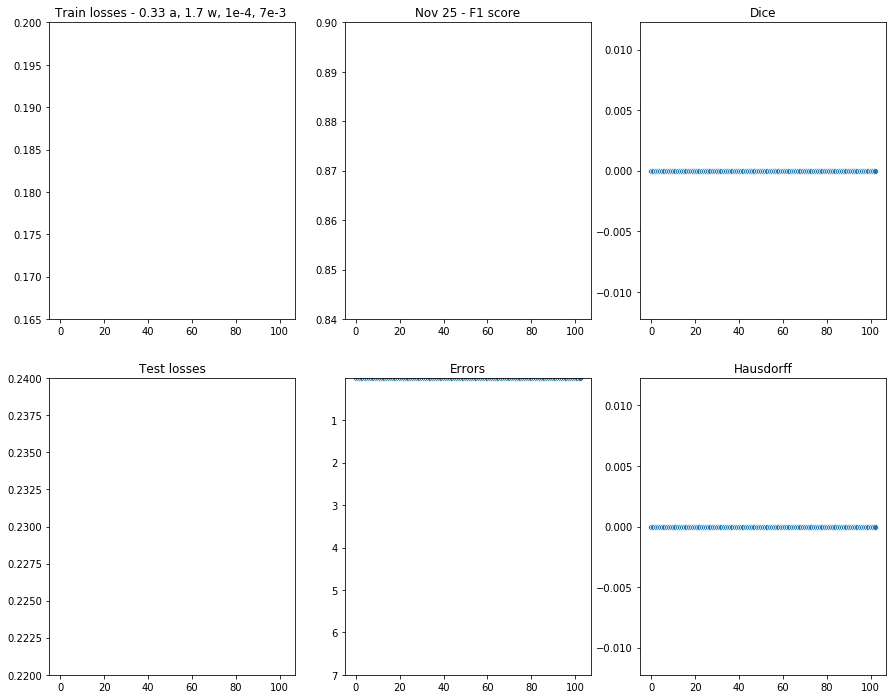

In [38]:
start = 0
end = 103

f, ((c1r1, c1r2, c1r3), (c2r1, c2r2, c2r3)) = plt.subplots(2, 3, sharey=False)
f.set_size_inches(15, 12)

c1r1.set_title("Train losses - 0.33 a, 1.7 w, 1e-4, 7e-3 ")
l1 = sns.scatterplot(y = metrics[0, start:end], x = np.arange(start, end),
               ax = c1r1)
l1.set(ylim=(0.165, .2))

c1r2.set_title("Nov 25 - F1 score")
f =sns.scatterplot(y = metrics[5, start:end], x = np.arange(start, end),
               ax = c1r2)
f.set(ylim=(0.84, .90))

c2r1.set_title("Test losses")
l = sns.scatterplot(y = metrics[1, start:end], x = np.arange(start, end),
               ax = c2r1)
l.set(ylim=(0.22, .24))

c2r2.set_title("Errors")
e = sns.scatterplot(y = metrics[2, start:end], x = np.arange(start, end),
               ax = c2r2)
e.set(ylim=(7, None))

c2r3.set_title("Hausdorff")
sns.scatterplot(y = metrics[3, start:end], x = np.arange(start, end),
               ax = c2r3)

c1r3.set_title("Dice")
sns.scatterplot(y = metrics[4, start:end], x = np.arange(start, end),
               ax = c1r3)
plt.show()

In [55]:
# Make sure that the equibatch is working with the augmentation
BATCH_SIZE = 32
randomize = equibatch(train_ids)
sum_no_equibatch = []
sum_equibatch = []
for k in tnrange(int(len(randomize) // BATCH_SIZE)):
    rand = [x for x in range(len(randomize))]
    batch_ids = rand[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
    _, y_batch = augment_batch(batch_ids, BATCH_SIZE)
    sum_no_equibatch.append(np.sum(y_batch))
    
for k in tnrange(int(len(randomize) // BATCH_SIZE)):
    batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
    _, y_batch = augment_batch(batch_ids, BATCH_SIZE)
    sum_equibatch.append(np.sum(y_batch))
    
print("No equibatch SD: {}".format(np.std(np.array(sum_no_equibatch))))
print("Equibatch SD: {}".format(np.std(np.array(sum_equibatch))))

[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717


/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/__main__.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/__main__.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



No equibatch SD: 1167.5450027015374
Equibatch SD: 115.11461712224103


# September changes
- Implement equibatch
- Implement 4x4 FPA, with CSSE in middle blocks
- Reduce label smoothing from 0.08 to 0.03
- reduce dropblock to 0.95 from 0.8

# Things to test
- Concatenating mean after GRU
- Turning of sse in GRU

In [41]:
def find_lr(epoch):
    path = f'{model_path}28-88-5/'
    saver.restore(sess, tf.train.latest_checkpoint(path))
    op = ft_op
    print("Using SGDM")
    BATCH_SIZE = 20
    test_lrs = [1e-4, 2e-4, 3e-4, 5e-4, 8e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 1e-2]
    #test_lrs = [5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 7e-5, 8e-5, 9e-5, 1e-4]
    losses = []
    train_ids = [x for x in range(len(train_y))]
    randomize = equibatch(train_ids)
    
    for k in tnrange(len(test_lrs)):
        loss_i = []
        for batch in tnrange(15):
            batch_ids = randomize[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
            x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
            x_median_input = calc_median_input(x_batch)
            ft_learning_rate = test_lrs[k]
            rmax_epoch, dmax_epoch, rmin_epoch = calc_renorm_params(epoch, len(train_y), BATCH_SIZE, k)
            opt, tr = sess.run([op, loss],
                              feed_dict={inp: x_batch,
                                         #inp_median: x_median_input,
                                         length: np.full((BATCH_SIZE, 1), 12),
                                         labels: y_batch,
                                         is_training: True,
                                         clipping_params['rmax']: rmax_epoch,
                                         clipping_params['rmin']: rmin_epoch,
                                         clipping_params['dmax']: dmax_epoch,
                                         loss_weight: 1.5,
                                         keep_rate: np.max(((1. - (i * 0.002)), 0.95)),
                                         alpha: np.min([epoch * 0.01, 0.33]),
                                         beta_: be,
                                         ft_lr: ft_learning_rate,
                                         })
            loss_i.append(tr)
        losses.append(np.mean(loss_i))
        print(test_lrs[k], np.mean(loss_i))
    return losses, test_lrs

#losses, test_lrs = find_lr(epoch = 28)
#sns.scatterplot(np.log10(test_lrs), losses)

In [57]:
# import scipy
best_val = 0.72
fine_tune = False
countries['all'] = [0, len(test_x)]
ft_epochs = 0
ft_learning_rate = .1
# 5e-5 until 50, adam for 266k model @20 batch
# 1e-4 after 50, momentum SGD

# new model 2e-4 until 30, 2e-3 sgdm after

for i in range(39, 150):
    al = np.min( [0.01 * (i - 1), 0.4] )
    #test_al = 0.3
    be = 0.0
    
    test_al = al
    #test_al = 0.33 if al < 0.8 else al
    print(ft_epochs)
    if fine_tune == True:
        op = ft_op
        #ft_epochs += 1
        #if ft_epochs % 20 == 0:
        #    ft_learning_rate /= 2
        #    print("DIVIDING LR")
        print(f"FINE TUNING WITH {ft_learning_rate} LR")
    else:
        op = train_op
        
    train_ids = [x for x in range(len(train_y))]
    randomize = equibatch(train_ids)
    print(f"starting epoch {i}, alpha: {al}, beta: {be} drop: {np.max(((1. - (i * 0.002)), 0.95))}")
    
    loss = train_loss
    BATCH_SIZE = 20
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        #rmax_epoch, dmax_epoch, rmin_epoch = calc_renorm_params(i, len(train_y), BATCH_SIZE, k)
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
        #x_median_input = calc_median_input(x_batch)
        opt, tr = sess.run([op, loss],
                          feed_dict={inp: x_batch,
                                     #inp_median: x_median_input,
                                     length: np.full((BATCH_SIZE, 1), 12),
                                     labels: y_batch,
                                     is_training: True,
                                     clipping_params['rmax']: 5,
                                     clipping_params['rmin']: 0,
                                     clipping_params['dmax']: 3,
                                     loss_weight: 1.5,
                                     keep_rate: np.max(((1. - (i * 0.002)), 0.95)),
                                     alpha: al,
                                     beta_: be,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
    
    print(f"Epoch {i}: Loss {np.around(np.mean(losses[:-1]), 3)}")
    run_metrics = False
    if (i > 60) and (i % 1) == 0:
        run_metrics = True
    elif i % 2 == 0:
        run_metrics = True
    if run_metrics:
        val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 75)
        metrics[0, i] = np.mean(losses[:-1])
        metrics[1, i] = val_loss
        metrics[2, i] = error
        metrics[3, i] = haus
        metrics[4, i] = dice
        metrics[5, i] = f1
        if f1 < (best_val - 0.002):
            ft_epochs += 1
        if f1 > (best_val - 0.02):
            print(f"Saving model with {f1}")
            np.save(f"{model_path}metrics.npy", metrics)
            os.mkdir(f"{model_path}{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/")
            save_path = saver.save(sess, f"{model_path}{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/model")
            if f1 > best_val:
                best_val = f1

0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 39, alpha: 0.38, beta: 0.0 drop: 0.95


/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/__main__.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Epoch 39: Loss 0.16699999570846558
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 40, alpha: 0.39, beta: 0.0 drop: 0.95



Epoch 40: Loss 0.1589999943971634
75
all: Val loss: 0.20000000298023224 Thresh: 0.45 F1: 0.894 R: 0.932 P: 0.86 D: 0.5 H: 0.5 Error: 7.517
Saving model with 0.8940947075208913
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 41, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 41: Loss 0.15299999713897705
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 42, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 42: Loss 0.1509999930858612
75
all: Val loss: 0.19599999487400055 Thresh: 0.45 F1: 0.896 R: 0.928 P: 0.866 D: 0.5 H: 0.5 Error: 7.518
Saving model with 0.8957571729256675
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 43, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 43: Loss 0.15299999713897705
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 44, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 44: Loss 0.14900000393390656
75
all: Val loss: 0.19900000095367432 Thresh: 0.45 F1: 0.895 R: 0.91 P: 0.88 D: 0.5 H: 0.5 Error: 7.936
Saving model with 0.8946866744737056
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 45, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 45: Loss 0.15600000321865082
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 46, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 46: Loss 0.1469999998807907
75
all: Val loss: 0.19699999690055847 Thresh: 0.45 F1: 0.895 R: 0.93 P: 0.862 D: 0.5 H: 0.5 Error: 7.724
Saving model with 0.8946622579121397
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 47, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 47: Loss 0.1459999978542328
0
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 48, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 48: Loss 0.14800000190734863
75
all: Val loss: 0.19699999690055847 Thresh: 0.45 F1: 0.892 R: 0.918 P: 0.867 D: 0.5 H: 0.5 Error: 7.796
Saving model with 0.8917520096905627
1
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 49, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 49: Loss 0.14900000393390656
1
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 50, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 50: Loss 0.1459999978542328
75
all: Val loss: 0.19699999690055847 Thresh: 0.45 F1: 0.892 R: 0.927 P: 0.859 D: 0.5 H: 0.5 Error: 7.788
Saving model with 0.8915394667333945
2
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 51, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 51: Loss 0.14399999380111694
2
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 52, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 52: Loss 0.14300000667572021
75
all: Val loss: 0.19499999284744263 Thresh: 0.45 F1: 0.892 R: 0.929 P: 0.858 D: 0.5 H: 0.5 Error: 7.702
Saving model with 0.8920190407259974
3
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 53, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 53: Loss 0.14399999380111694
3
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 54, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 54: Loss 0.14300000667572021
75
all: Val loss: 0.1979999989271164 Thresh: 0.45 F1: 0.894 R: 0.903 P: 0.885 D: 0.5 H: 0.5 Error: 8.289
Saving model with 0.8943581976524043
3
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 55, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 55: Loss 0.1420000046491623
3
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 56, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 56: Loss 0.13899999856948853
75
all: Val loss: 0.19599999487400055 Thresh: 0.45 F1: 0.897 R: 0.915 P: 0.88 D: 0.5 H: 0.5 Error: 8.264
Saving model with 0.8974288989573668
3
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 57, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 57: Loss 0.14000000059604645
3
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 58, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 58: Loss 0.14300000667572021
75
all: Val loss: 0.20200000703334808 Thresh: 0.45 F1: 0.893 R: 0.898 P: 0.888 D: 0.5 H: 0.5 Error: 8.969
Saving model with 0.8929340801378716
4
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 59, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 59: Loss 0.14300000667572021
4
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 60, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 60: Loss 0.14000000059604645
75
all: Val loss: 0.19599999487400055 Thresh: 0.45 F1: 0.899 R: 0.925 P: 0.876 D: 0.5 H: 0.5 Error: 7.672
Saving model with 0.8994691531204445
4
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 61, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 61: Loss 0.13899999856948853
75
all: Val loss: 0.19499999284744263 Thresh: 0.45 F1: 0.894 R: 0.929 P: 0.862 D: 0.5 H: 0.5 Error: 7.859
Saving model with 0.8944648216072025
5
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 62, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 62: Loss 0.13899999856948853
75
all: Val loss: 0.19499999284744263 Thresh: 0.45 F1: 0.901 R: 0.926 P: 0.877 D: 0.5 H: 0.5 Error: 7.337
Saving model with 0.9007259927400727
5
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 63, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 63: Loss 0.1459999978542328
75
all: Val loss: 0.19900000095367432 Thresh: 0.45 F1: 0.881 R: 0.948 P: 0.822 D: 0.5 H: 0.5 Error: 8.019
6
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 64, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 64: Loss 0.1509999930858612
75
all: Val loss: 0.20100000500679016 Thresh: 0.45 F1: 0.886 R: 0.898 P: 0.875 D: 0.5 H: 0.5 Error: 8.551
Saving model with 0.8862428121948573
7
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 65, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 65: Loss 0.14000000059604645
75
all: Val loss: 0.1979999989271164 Thresh: 0.45 F1: 0.893 R: 0.921 P: 0.868 D: 0.5 H: 0.5 Error: 7.803
Saving model with 0.8933307601113837
8
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 66, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 66: Loss 0.15000000596046448
75
all: Val loss: 0.20200000703334808 Thresh: 0.45 F1: 0.88 R: 0.889 P: 0.87 D: 0.5 H: 0.5 Error: 8.982
9
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 67, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 67: Loss 0.14300000667572021
75
all: Val loss: 0.1979999989271164 Thresh: 0.45 F1: 0.892 R: 0.919 P: 0.866 D: 0.5 H: 0.5 Error: 7.777
Saving model with 0.8917204479011529
10
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 68, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 68: Loss 0.13899999856948853
75
all: Val loss: 0.1979999989271164 Thresh: 0.45 F1: 0.887 R: 0.902 P: 0.872 D: 0.5 H: 0.5 Error: 8.74
Saving model with 0.8865715530385537
11
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 69, alpha: 0.4, beta: 0.0 drop: 0.95



Epoch 69: Loss 0.13699999451637268
75
all: Val loss: 0.20000000298023224 Thresh: 0.45 F1: 0.889 R: 0.895 P: 0.883 D: 0.5 H: 0.5 Error: 8.057
Saving model with 0.8893381857393181
12
[1082, 545, 544, 343, 351, 335, 364, 320, 833]
4717
starting epoch 70, alpha: 0.4, beta: 0.0 drop: 0.95


KeyboardInterrupt: 

In [ ]:
val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 75)

# Prediction visualizations

In [ ]:
test_ids = [x for x in range(len(test_x))]
diffs = []
for idx in tnrange(len(test_ids)):
    x_input = test_x[idx].reshape(1, 13, 24, 24, n_bands)
    median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: np.full((1, 1), 12),
                                  is_training: False,
                                  clipping_params['rmax']: 5,
                                  clipping_params['rmin']: 0,
                                  clipping_params['dmax']: 3,
                                  })
    y = np.array(y).reshape(14, 14)
    y[np.where(y > 0.45)] = 1.0
    y[np.where(y < 0.45)] = 0.
    diff = np.sum(y) - np.sum(test_y[idx])
    diffs.append(diff)

In [40]:
start = 12


#test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show



In [47]:
start = 12

0.028282828282828285
[28, 29, 30, 31, 32, 33, 34, 35]


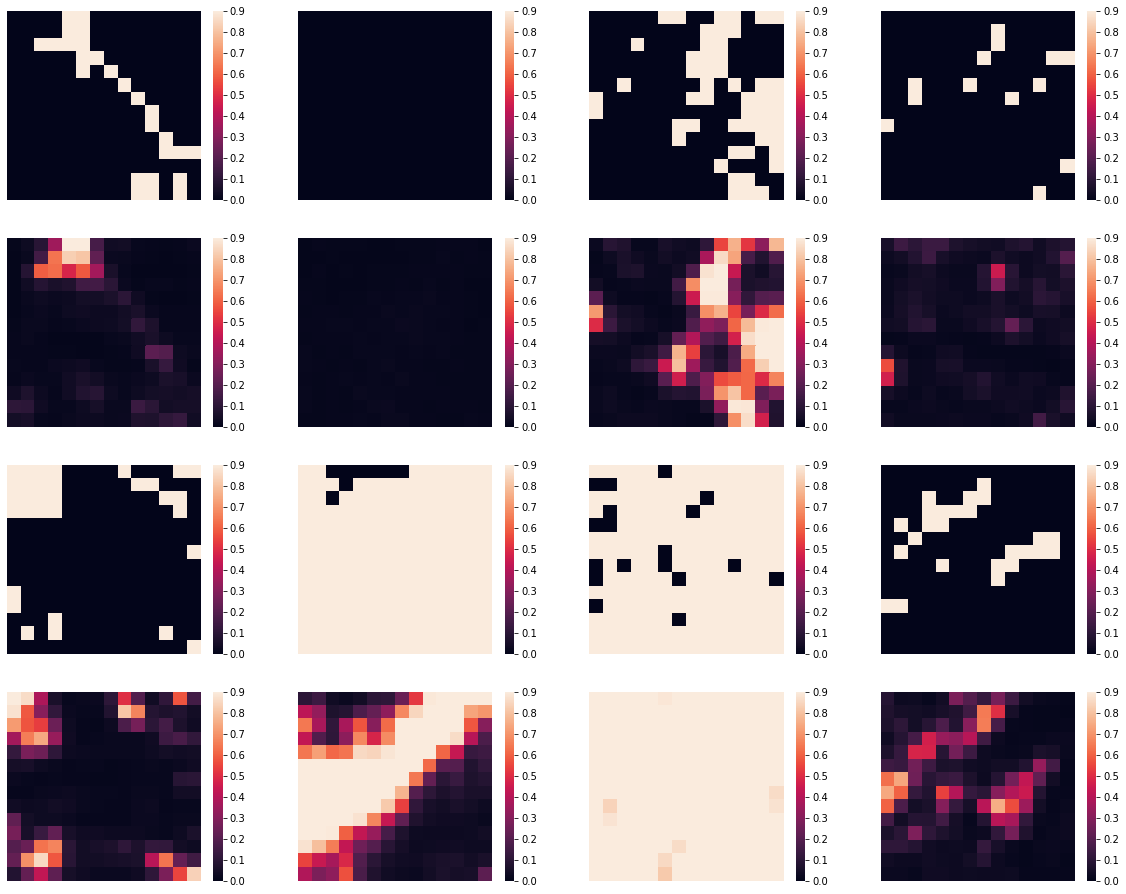

In [50]:
### from sklearn.metrics import f1_score
print(start/len(test_ids))
test_ids = [x for x in range(test_x.shape[0])]
test_ids = sorted(test_ids)
#test_ids = np.argwhere(abs(np.array(diffs)) > 15)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]


preds = []
trues = []
print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = test_x[idx].reshape(1, 13, 24, 24, n_bands)
    median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: np.full((1, 1), 12),
                                  is_training: False,
                                  clipping_params['rmax']: 5,
                                  clipping_params['rmin']: 0,
                                  clipping_params['dmax']: 3,
                                  })
    y = np.array(y).reshape(14, 14)
    #print(i, test_data.iloc[i]['lat'], test_data.iloc[i]['long'])
    #print(i, (list(test_data.iloc[idx, 1])[0], list(test_data.iloc[idx, 2])[0]), diffs[i[0]])
    #y, mapshape = aggregate_maxes(test_y[idx], y)
    preds.append(y)
    y2 = np.copy(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)

start = start + 8 

# 123, 334, 680, 875, 917, 950

In [ ]:
train_ids = [x for x in range(len(train_y))]
diffs = []
for idx in tnrange(len(train_ids)):
    x_input = train_x[idx].reshape(1, 13, 24, 24, n_bands)
    median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: 5,
                                  clipping_params['rmin']: 0,
                                  clipping_params['dmax']: 3,
                                  })
    y = np.array(y).reshape(14, 14)
    y[np.where(y > 0.45)] = 1.0
    y[np.where(y < 0.45)] = 0.
    diff = np.sum(y) - np.sum(train_y[idx])
    diffs.append(diff)

In [41]:
train_ids = [x for x in range(train_x.shape[0])]
train_ids = sorted(train_ids)
start = 0

In [125]:
#train_ids = np.argwhere(np.logical_and(abs(np.array(diffs)) >= 50,
 #                                     abs(np.array(diffs)) < 200))

matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2],
             train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7]]
preds = []
trues = []
#print(start//4)
print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = train_x[idx].reshape(1, 13, 24, 24, n_bands)
    #median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: np.full((1, 1), 12),
                                  is_training: False,
                                  clipping_params['rmax']: 5,
                                  clipping_params['rmin']: 0,
                                  clipping_params['dmax']: 3,
                                    })
    y = np.array(y).reshape(14, 14)
    
    #y, _ = aggregate_maxes(train_y[idx], y)
    
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    
    #print(idx, (list(data.iloc[idx, 1])[0], list(data.iloc[idx, 2])[0]), diffs[i[0]], np.sum(y) - np.sum(true))
    print(idx, data.iloc[i, 0], data.iloc[i, 1],
          data.iloc[i, 2])#, diffs[i[0]])
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)

IndexError: list index out of range